## Compute Relative Nino-3.4/ONI based on J. Climate paper

In [13]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Extract ERSSTv5 data from NOAA PSL THREDDS portal

https://psl.noaa.gov/data/gridded/data.noaa.ersst.v5.html

In [2]:
url = 'http://psl.noaa.gov/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
dat = xr.open_dataset(url)
# drop time_bnds
dat = dat.drop_vars("time_bnds")
print(dat)

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 2037)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2023-09-01
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes: (12/39)
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    ...                              ...
    comment:                         SSTs were observed by conventional therm...
    summary:            

## Isolate time range (as needed)

In [3]:
dat = dat.sel(time=slice('1950-01-01', '2023-09-01'))

# Tropical Mean index (total)

Text(0.5, 1.0, 'Tropical SST Average Index')

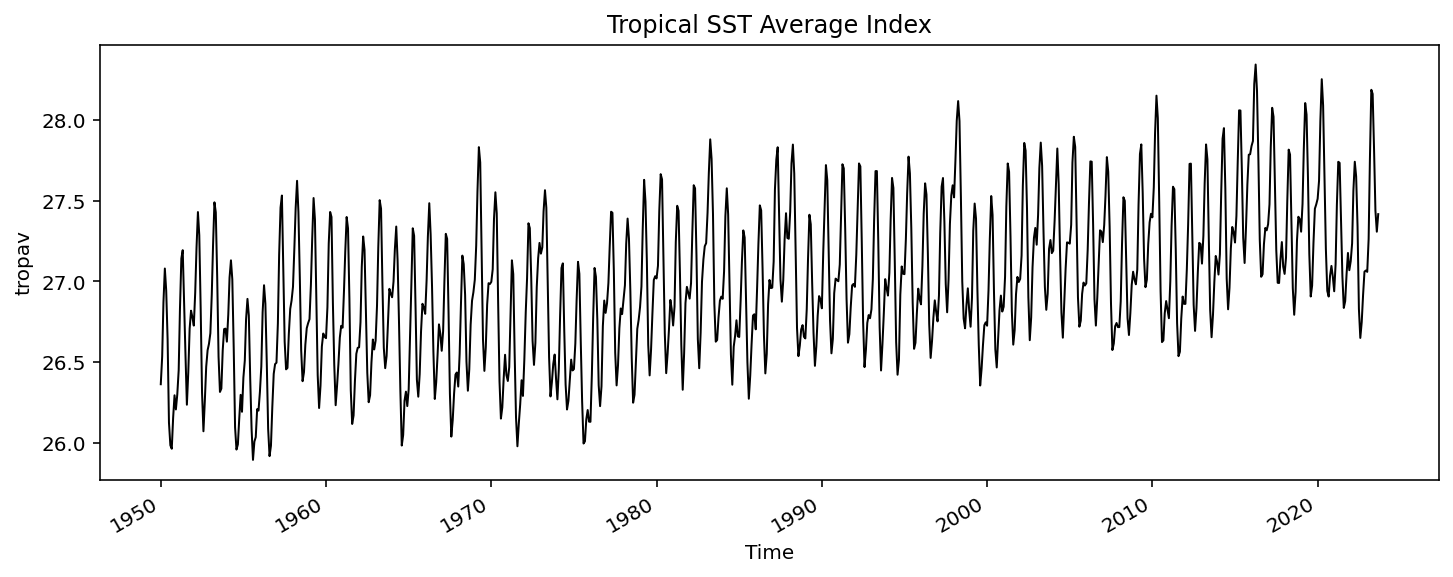

In [4]:
tropdomain = dat.sel(lat=slice(20, -20), lon=slice(0, 360))
tropav = tropdomain.mean(dim=('lat','lon'))
tropav = tropav.rename({'sst':'tropav'})

fig, ax = plt.subplots(figsize=(12, 4))
tropav.tropav.plot(ax=ax,x='time',linewidth=1,color='black')
plt.title('Tropical SST Average Index')

# Nino-3.4 index (total)

Text(0.5, 1.0, 'Nino-3.4 Average Index')

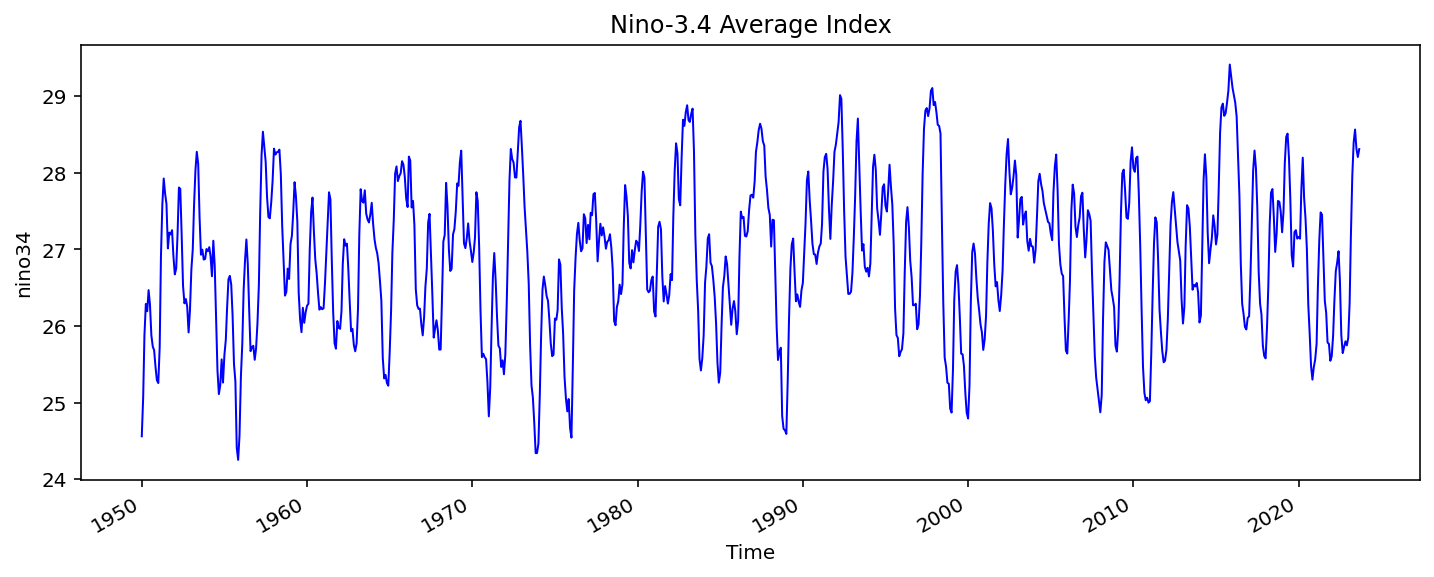

In [5]:
ninodomain = dat.sel(lat=slice(5, -5), lon=slice(190, 240))
nino34 = ninodomain.mean(dim=('lat','lon'))
nino34 = nino34.rename({'sst':'nino34'})

fig, ax = plt.subplots(figsize=(12, 4))
nino34.nino34.plot(ax=ax,x='time',linewidth=1,color='blue')
plt.title('Nino-3.4 Average Index')

## Remove climatology to create anonamly 

In [6]:
# Set climatology 
climrang1 = '1991-01-01'
climrang2 = '2020-12-01'

# Nino3.4 anomaly
clm = nino34.sel(time=slice(climrang1,climrang2)).groupby('time.month').mean(dim='time')
nino34a = (nino34.groupby('time.month') - clm)
# Trop mean anomaly
clm = tropav.sel(time=slice(climrang1,climrang2)).groupby('time.month').mean(dim='time')
tropa = (tropav.groupby('time.month') - clm)

## Subtract tropical mean anomaly from Nino3.4 anomaly then apply scaling to match original variance

In [7]:
diff_idx = nino34a['nino34'] - tropa['tropav']

# Adjust variance 
f = nino34a.sel(time=slice('1950-01-01', '2023-12-01'))
r = diff_idx.sel(time=slice('1950-01-01', '2023-12-01'))
scaling_factor = f.groupby('time.month').std('time') / r.groupby('time.month').std('time')
scaled_reln34a = diff_idx.groupby('time.month') * scaling_factor
scaled_reln34a = scaled_reln34a.rename({'nino34':'relnino34a'})

## Test variance by month

Text(0.5, 1.0, 'Monthly Standard Deviation')

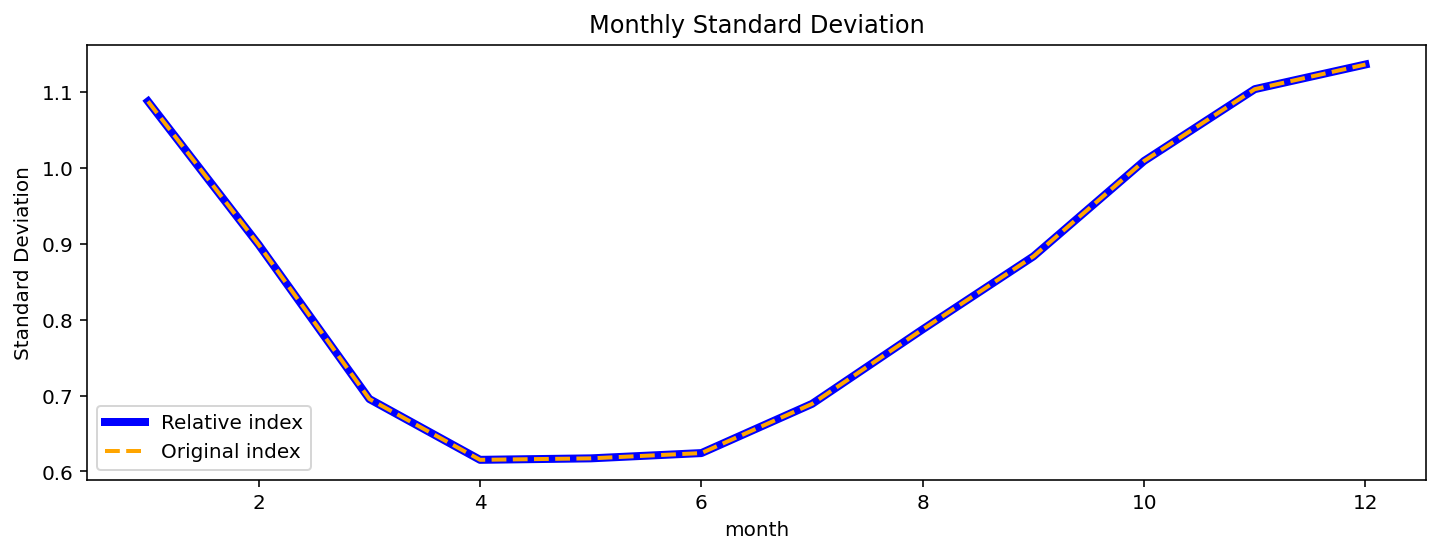

In [8]:
relvar = scaled_reln34a.groupby('time.month').std('time')
origvar = nino34a.groupby('time.month').std('time')

fig, ax = plt.subplots(figsize=(12, 4))
relvar.relnino34a.plot(ax=ax,x='month',linewidth=4,color='blue',label='Relative index')
origvar.nino34.plot(ax=ax,x='month',linewidth=2,color='orange',linestyle='dashed',label='Original index')
plt.legend()
plt.ylabel('Standard Deviation')
plt.title('Monthly Standard Deviation')

## Compute Relative ONI (3 month running mean) and compare to ONI.  Time now refers to centered month of season.  

In [9]:
RONI = scaled_reln34a.rolling(time=3, center=True).mean()
RONI = RONI.dropna(dim="time", how="any") # drop nan
RONI = RONI.rename({'relnino34a':'RONI'})

ONI = nino34a.rolling(time=3, center=True).mean()
ONI = ONI.dropna(dim="time", how="any") # drop nan
ONI = ONI.rename({'nino34':'ONI'})

Text(0.5, 1.0, 'ONI and Relative ONI')

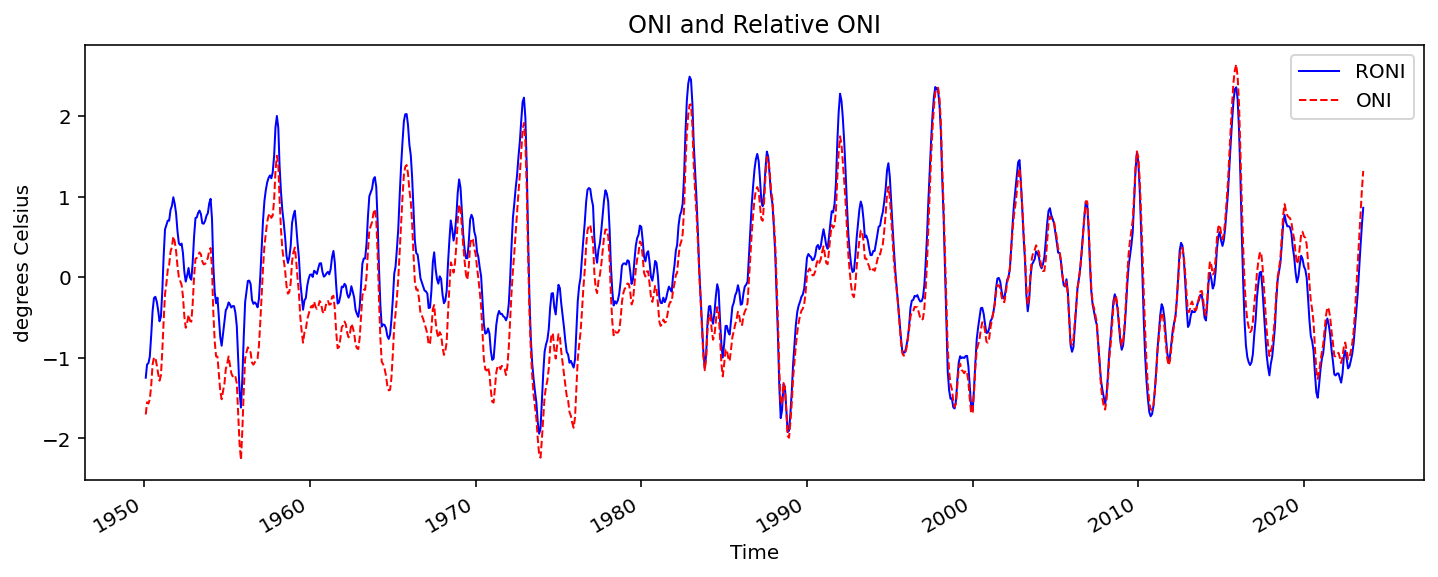

In [10]:
fig, ax = plt.subplots(figsize=(12, 4))
RONI.RONI.plot(ax=ax,x='time',linewidth=1,color='blue',label='RONI')
ONI.ONI.plot(ax=ax,x='time',linewidth=1,color='red',linestyle='dashed',label='ONI')
plt.legend()
plt.ylabel('degrees Celsius')
plt.title('ONI and Relative ONI')

# plot differences

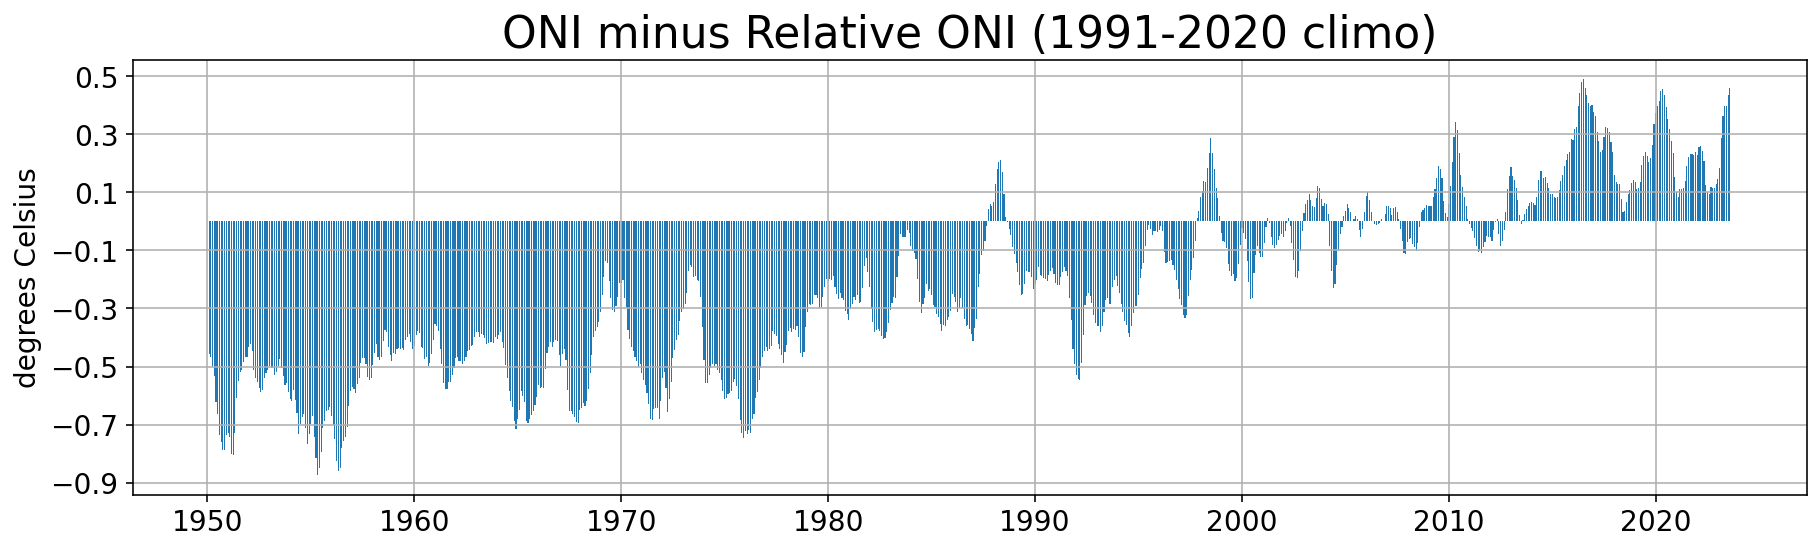

In [14]:
diff = ONI.ONI - RONI.RONI

fig, ax = plt.subplots(figsize=(15, 4))
ax.bar(diff.time, diff.values, width=19.5)
ax.set_title('ONI minus Relative ONI (1991-2020 climo)',fontsize=22)
ax.set_ylabel('degrees Celsius',fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_yticks(np.arange(-0.9, 0.6, step=.2))
ax.grid()

# Output RONI file to netcdf

In [15]:
print(RONI)
RONI.to_netcdf("RONI.nc")

<xarray.Dataset>
Dimensions:  (time: 883)
Coordinates:
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 10 11 12 1 2 3 4 5 6 7 8
  * time     (time) datetime64[ns] 1950-02-01 1950-03-01 ... 2023-08-01
Data variables:
    RONI     (time) float64 -1.246 -1.083 -1.065 ... 0.3754 0.6347 0.8628
